# 1. Data

## 1.1 3D Semantic Labeling Contest Datasets

![area](data/area.jpg)

In [9]:
import pandas as pd

train_data = pd.read_csv('data/Vaihingen3D_Traininig.pts', sep=" ", header=None)
train_data.columns = ["x", "y", "z", "int", "ret", "num", "class"]
train_data.head()

,x,y,z,int,ret,num,class
0,496848.91,5419403.58,265.46,19,1,1,1
1,496848.92,5419403.97,265.43,24,1,1,1
2,496848.93,5419404.35,265.40,31,1,1,1
3,496848.94,5419404.73,265.36,33,1,1,1
4,496849.34,5419405.72,265.30,44,1,1,1


## Dataset Detail

|Class        | power | low\_veg | imp\_surf | car   | fence\_hedge | roof    | fac    | shrub  | tree    | Total |
|---|---|---|---|---|---|---|---|---|---|---|
|Training Set | 546   | 180,850  | 193,723   | 4,614 | 12,070       | 152,045 | 27,250 | 47,605 | 135,173 | 753,876 |
|Test Set     | 600   | 98,690   | 101,986   | 3,708 | 7,422        | 109,048 | 11,224 | 24,818 | 54,226  | 411,722 | 

## Visualization

![vis](data/dataset.png)

In [13]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

cfg = {0:["o","#c0c0c0"],1:["v","#00ff00"],2:["^","#ebeff2"],3:["s","#000000"],
       4:["P","#00ff81"],5:["*","#ff8000"],6:["h","#ffff00"],7:["d","#008080"],8:["X","#004040"]}


In [21]:
def vis(datas):

    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111, projection='3d')
    
    for data in datas:
        ax.scatter(data[0], data[1], data[2], s=0.5, marker=cfg[data[6]][0], c=cfg[data[6]][1])        

    plt.grid(True)
    plt.show()


In [27]:
datas = np.loadtxt('data/Vaihingen3D_Traininig.pts')


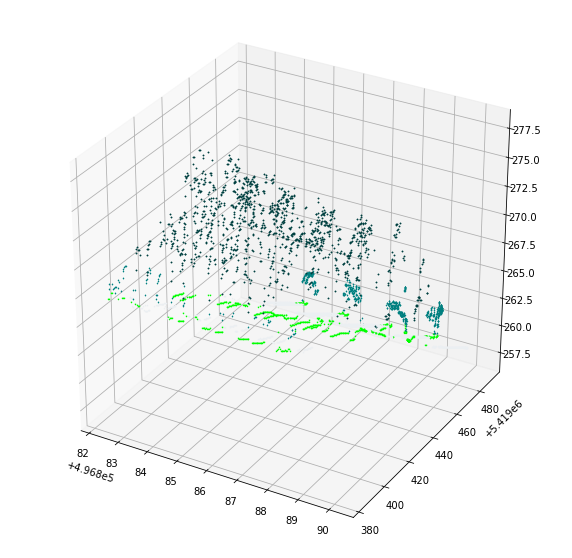

In [26]:
# Random Area （The whole data is too large）

vis(datas[10000:14000])

## 1.2 Data processing

![proce](data/data.png)

In [29]:

def data_proce(data_path, num_point=1024, block_size=30, stride=10, padding=0.02, rate=0.8):
    data = np.loadtxt(data_path)  # xyzrgbl, N*7
    
    coord_min, coord_max = np.amin(data, axis=0)[:4], np.amax(data, axis=0)[:4]
    
    grid_x = int(np.ceil(float(coord_max[0] - coord_min[0] - block_size) / stride) + 1)
    grid_y = int(np.ceil(float(coord_max[1] - coord_min[1] - block_size) / stride) + 1)
    
    all_data_patch = []
    num_point_all = []

    # 
    for index_y in range(0, grid_y):
        for index_x in range(0, grid_x):
            s_x = coord_min[0] + index_x * stride
            e_x = min(s_x + block_size, coord_max[0])
            s_x = e_x - block_size
            s_y = coord_min[1] + index_y * stride
            e_y = min(s_y + block_size, coord_max[1])
            s_y = e_y - block_size
            point_idxs = np.where(
                (data[:, 0] >= s_x - padding) & (data[:, 0] <= e_x + padding) & (data[:, 1] >= s_y - padding) & (
                            data[:, 1] <= e_y + padding))[0]
            if point_idxs.size == 0:
                continue
            
            all_data_patch.append(data[point_idxs])
            num_point_all.append(point_idxs.size)

    sample_prob = num_point_all / np.sum(num_point_all)
    num_iter = int(np.sum(num_point_all) / num_point)
    room_idxs = []
    for index in range(len(num_point_all)):
        room_idxs.extend([int(round(sample_prob[index] * num_iter))])
    room_idxs = np.array(room_idxs)
    all_data_patch = np.array(all_data_patch)

    idx = np.where(room_idxs==0)
    all_data_patch = np.delete(all_data_patch, idx)
    room_idxs = np.delete(room_idxs, idx)
    
    idx = np.random.choice(np.arange(room_idxs.size), int(room_idxs.size * rate))
    train_data = all_data_patch[idx]
    train_idx = room_idxs[idx]
    test_data = np.delete(all_data_patch, idx)
    test_idx = np.delete(room_idxs, idx)
    return train_data, train_idx, test_data, test_idx



In [32]:
train_data1, train_idx1, test_data1, test_idx1 = data_proce('Vaihingen3D_Traininig.pts')

train_data = np.append(train_data1, train_data2)

train_idxs = []
for index in range(len(train_idx1)):
    train_idxs.extend([index] * train_idx1[index])

test_idxs = []
for index in range(len(test_data1)):
    test_idxs.extend([index] * test_idx1[index])

np.save('train.npy', {'data':train_data, 'idx':train_idxs})
np.save('test.npy', {'data':test_data, 'idx':test_idxs})

# 2. DAPnet

![nets](data/dapnet.jpg)

In [34]:
import torch.nn as nn
import torch.nn.functional as F
from models.pointnet_util import PointNetSetAbstraction,PointNetSetPAGAAbstraction,PointNetFeaturePropagation

class get_model(nn.Module):
    def __init__(self, num_classes):
        super(get_model, self).__init__()
        self.sa1 = PointNetSetAbstraction(256, 0.1, 32, 9 + 3, [32, 32, 64], False)
        self.sa2 = PointNetSetAbstraction(128, 0.2, 32, 64 + 3, [64, 64, 128], False)
        self.sa3 = PointNetSetAbstraction(64, 0.4, 32, 128 + 3, [128, 128, 256], False)
        self.sa4 = PointNetSetPAGAAbstraction(32, 0.8, 32, 256 + 3, [256, 256, 512], False)
        self.fp4 = PointNetFeaturePropagation(768, [256, 256])
        self.fp3 = PointNetFeaturePropagation(384, [256, 256])
        self.fp2 = PointNetFeaturePropagation(320, [256, 128])
        self.fp1 = PointNetFeaturePropagation(128, [128, 128, 128])
        self.conv1 = nn.Conv1d(128, 128, 1)
        self.bn1 = nn.BatchNorm1d(128)
        self.drop1 = nn.Dropout(0.5)
        self.conv2 = nn.Conv1d(128, num_classes, 1)

    def forward(self, xyz):
        l0_points = xyz
        l0_xyz = xyz[:,:3,:]

        l1_xyz, l1_points = self.sa1(l0_xyz, l0_points)
        l2_xyz, l2_points = self.sa2(l1_xyz, l1_points)
        l3_xyz, l3_points = self.sa3(l2_xyz, l2_points)
        l4_xyz, l4_points = self.sa4(l3_xyz, l3_points)

        l3_points = self.fp4(l3_xyz, l4_xyz, l3_points, l4_points)
        l2_points = self.fp3(l2_xyz, l3_xyz, l2_points, l3_points)
        l1_points = self.fp2(l1_xyz, l2_xyz, l1_points, l2_points)
        l0_points = self.fp1(l0_xyz, l1_xyz, None, l1_points)

        x = self.drop1(F.relu(self.bn1(self.conv1(l0_points))))
        x = self.conv2(x)
        x = F.log_softmax(x, dim=1)
        x = x.permute(0, 2, 1)
        return x, l4_points


class get_loss(nn.Module):
    def __init__(self):
        super(get_loss, self).__init__()
    def forward(self, pred, target, trans_feat, weight):
        total_loss = F.nll_loss(pred, target, weight=weight)

        return total_loss

## 2.1 Double Self-Attention Module

In [36]:
from time import time
import numpy as np
import math
import torch
import torch.nn as nn
from torch.nn import Module, Sequential, Conv2d, ReLU,AdaptiveMaxPool2d, AdaptiveAvgPool2d, \
    NLLLoss, BCELoss, CrossEntropyLoss, AvgPool2d, MaxPool2d, Parameter, Linear, Sigmoid, Softmax, Dropout, Embedding
from torch.nn import functional as F
from torch.autograd import Variable

## 2.2 Point Attention Module

![point](data/point.jpg)

In [37]:
class PAM_Module(Module):
    """ Position attention module"""
    #Ref from SAGAN
    def __init__(self, in_dim):
        super(PAM_Module, self).__init__()
        self.chanel_in = in_dim

        self.query_conv = Conv2d(in_channels=in_dim, out_channels=in_dim//8, kernel_size=1)
        self.key_conv = Conv2d(in_channels=in_dim, out_channels=in_dim//8, kernel_size=1)
        self.value_conv = Conv2d(in_channels=in_dim, out_channels=in_dim, kernel_size=1)
        self.gamma = Parameter(torch.zeros(1))

        self.softmax = Softmax(dim=-1)
    def forward(self, x):
        """
            inputs :
                x : input feature maps( B X C X H X W)
            returns :
                out : attention value + input feature
                attention: B X (HxW) X (HxW)
        """
        m_batchsize, C, height, width = x.size()
        proj_query = self.query_conv(x).view(m_batchsize, -1, width*height).permute(0, 2, 1)
        proj_key = self.key_conv(x).view(m_batchsize, -1, width*height)
        energy = torch.bmm(proj_query, proj_key)
        attention = self.softmax(energy)
        proj_value = self.value_conv(x).view(m_batchsize, -1, width*height)

        out = torch.bmm(proj_value, attention.permute(0, 2, 1))  
        out = out.view(m_batchsize, C, height, width)

        out = self.gamma*out + x
        return out

## 2.3 Group Attention Module

![group](data/group.jpg)

In [38]:
class GAM_Module(Module):
    """ Group attention module"""
    def __init__(self, in_dim):
        super(GAM_Module, self).__init__()
        self.chanel_in = in_dim


        self.gamma = Parameter(torch.zeros(1))
        self.softmax  = Softmax(dim=-1)
    def forward(self,x):
        """
            inputs :
                x : input feature maps( B X C X H X W)
            returns :
                out : attention value + input feature
                attention: B X C X C
        """
        m_batchsize, C, height, width = x.size()
        proj_query = x.view(m_batchsize, C, -1)
        proj_key = x.view(m_batchsize, C, -1).permute(0, 2, 1)
        energy = torch.bmm(proj_query, proj_key)
        energy_new = torch.max(energy, -1, keepdim=True)[0].expand_as(energy)-energy
        attention = self.softmax(energy_new)
        proj_value = x.view(m_batchsize, C, -1)

        out = torch.bmm(attention, proj_value)
        out = out.view(m_batchsize, C, height, width)

        out = self.gamma*out + x
        return out


## 3. Ttraining the model

```python

python train_isprs.py --model pointnet2_isprs_all --block_size 35 --npoint 1024 --log_dir ISPRS


parser.add_argument('--model', type=str, default='pointnet_sem_seg', help='model name [default: pointnet_sem_seg]')
parser.add_argument('--batch_size', type=int, default=16, help='Batch Size during training [default: 16]')
parser.add_argument('--epoch',  default=128, type=int, help='Epoch to run [default: 128]')
parser.add_argument('--learning_rate', default=0.001, type=float, help='Initial learning rate [default: 0.001]')
parser.add_argument('--gpu', type=str, default='0', help='GPU to use [default: GPU 0]')
parser.add_argument('--optimizer', type=str, default='Adam', help='Adam or SGD [default: Adam]')
parser.add_argument('--log_dir', type=str, default=None, help='Log path [default: None]')
parser.add_argument('--decay_rate', type=float, default=1e-4, help='weight decay [default: 1e-4]')
parser.add_argument('--npoint', type=int,  default=512, help='Point Number [default: 4096]')
parser.add_argument('--step_size', type=int,  default=10, help='Decay step for lr decay [default: every 10 epochs]')
parser.add_argument('--lr_decay', type=float,  default=0.7, help='Decay rate for lr decay [default: 0.7]')
parser.add_argument('--block_size', type=int, default=30, help='the size of the patch')
```

